In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, fnmatch

import scipy
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift,dct
from scipy import interpolate
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
import torch
import re
import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1rgBXW0nsgJHVTeiTmbwyZRhQ3mk80B6N' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1rgBXW0nsgJHVTeiTmbwyZRhQ3mk80B6N" -O set_ab.rar && rm -rf /tmp/cookies.txt

--2021-02-28 08:29:10--  https://docs.google.com/uc?export=download&confirm=kbUl&id=1rgBXW0nsgJHVTeiTmbwyZRhQ3mk80B6N
Resolving docs.google.com (docs.google.com)... 74.125.195.102, 74.125.195.101, 74.125.195.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-ag-docs.googleusercontent.com/docs/securesc/8iudjt5cqh9j1qmsckjsppdtq5n3cf2c/8d5i2s31nlg93l2jkhbb7utkqb3pmesr/1614500925000/00100128714342052059/09446094268773784735Z/1rgBXW0nsgJHVTeiTmbwyZRhQ3mk80B6N?e=download [following]
--2021-02-28 08:29:10--  https://doc-0g-ag-docs.googleusercontent.com/docs/securesc/8iudjt5cqh9j1qmsckjsppdtq5n3cf2c/8d5i2s31nlg93l2jkhbb7utkqb3pmesr/1614500925000/00100128714342052059/09446094268773784735Z/1rgBXW0nsgJHVTeiTmbwyZRhQ3mk80B6N?e=download
Resolving doc-0g-ag-docs.googleusercontent.com (doc-0g-ag-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting

In [ ]:
!mkdir data_set
!mkdir data_filt
!sudo apt install unrar
!unrar e set_ab.rar data_set/

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unrar is already the newest version (1:5.5.8-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from set_ab.rar

Extracting  data_set/artifact__201012172012.wav                            0%  OK 
Extracting  data_set/artifact__201105040918.wav                            0%  1%  OK 
Extracting  data_set/artifact__201105041959.wav                            1%  OK 
Extracting  data_set/artifact__201105051017.wav                            1%  2%  OK 
Extracting  data_set/artifact__201105060108.wav                            2%  3%  OK 
Extracting  data_set/artifact__201105061143.wav                            3%  OK 
Extracting  data_set/artifact__201105190800.wav                            3%  4%  OK 
Extracting  data_s

# Filtering and writing files

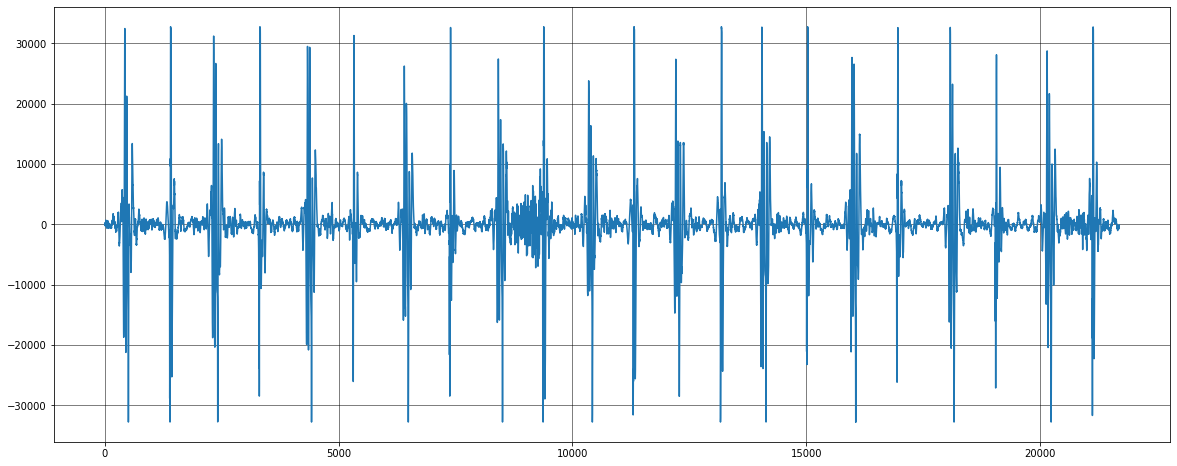

In [ ]:
# let's look at the envelope of the signal
fs, data = wavfile.read('data_set/normal__235_1308749032454_D.wav')

plt.figure(figsize=(20,8))
plt.plot(data)
plt.grid(color='k', linestyle='-', linewidth=0.5)

Since heart beat sound is low-frequency, it makes sence to filter it with LP filter to clean the signal from high-frequency noise such as speech, radio, and other non-heart sounds, we can hear in audio

I've took the Butterworth filter, so here is an example of how it works


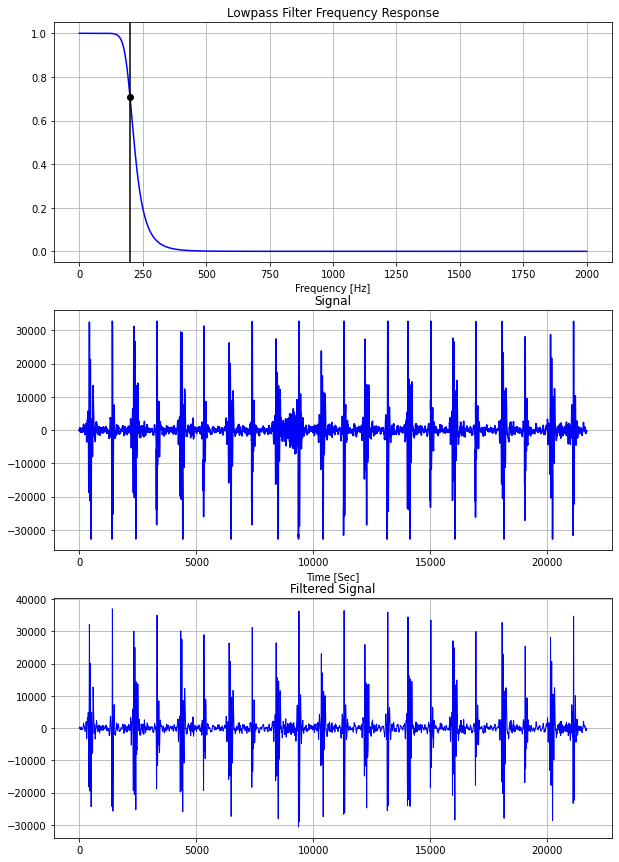

In [ ]:
fc = 200  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
b, a = signal.butter(7, w, 'low')
y = signal.filtfilt(b, a, data)

fig,(ax0,ax1,ax2) = plt.subplots(3,1,figsize=(10,15))

w, h = signal.freqz(b, a, worN=8000)
ax0.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
ax0.plot(fc, 0.5*np.sqrt(2), 'ko')
ax0.axvline(fc, color='k')
ax0.set_title("Lowpass Filter Frequency Response")
ax0.set(xlabel='Frequency [Hz]')
ax0.grid()

ax1.set_title("Signal")
ax1.plot(data, 'b-', label='data')
ax1.set(xlabel='Time [Sec]')
ax1.grid()

ax2.set_title("Filtered Signal")
ax2.plot(y, 'b-', linewidth=1, label='filtered data')
ax1.set(xlabel='Time [Sec]')
ax2.grid()

In [ ]:
#function for LP filtering and writing filtered files

def filter_file(directory,name,fc,filter_order,directory_out):
    """
    fc - cutoff frequency
    filter_order - the order of the Butterworth filter
    directory_out - directory in which write filtered files
    """
    fs, fin = wavfile.read(directory+name)
    w = fc / (fs / 2)                               # Normalize the frequency
    b, a = signal.butter(filter_order, w, 'low')
    fout = signal.filtfilt(b, a, fin)
    
    #creating new filename by adding '_filt' at the end
    index = name.find('.wav')
    name_out = name[:index]+'_filt'+name[index:]
    print(directory_out+name_out)
    wavfile.write(directory_out+name_out, fs, fout.astype(np.int16))

In [ ]:
folder = 'data_set/'
folder_filt = 'data_filt/'

for fil in fnmatch.filter(os.listdir(folder),'extrahls*.wav'):
  filter_file(folder,fil,250,7,folder_filt)
  
for fil in fnmatch.filter(os.listdir(folder),'artifact*.wav'):
  filter_file(folder,fil,250,7,folder_filt)
    
for fil in fnmatch.filter(os.listdir(folder),'murmur*.wav'):
  filter_file(folder,fil,250,7,folder_filt)

for fil in fnmatch.filter(os.listdir(folder),'normal*.wav'):
  filter_file(folder,fil,250,7,folder_filt)

data_filt/extrahls__201102071835_filt.wav
data_filt/extrahls__201104270459_filt.wav
data_filt/extrahls__201101152255_filt.wav
data_filt/extrahls__201101161027_filt.wav
data_filt/extrahls__201101070953_filt.wav
data_filt/extrahls__201103200218_filt.wav
data_filt/extrahls__201101160804_filt.wav
data_filt/extrahls__201101091153_filt.wav
data_filt/extrahls__201101241433_filt.wav
data_filt/extrahls__201104140118_filt.wav
data_filt/extrahls__201101160808_filt.wav
data_filt/extrahls__201104270458_filt.wav
data_filt/extrahls__201102241217_filt.wav
data_filt/extrahls__201103150114_filt.wav
data_filt/extrahls__201101241423_filt.wav
data_filt/extrahls__201104021355_filt.wav
data_filt/extrahls__201103170134_filt.wav
data_filt/extrahls__201103182227_filt.wav
data_filt/extrahls__201102070251_filt.wav
data_filt/artifact__201106212112_filt.wav
data_filt/artifact__201106101955_filt.wav
data_filt/artifact__201106220340_filt.wav
data_filt/artifact__201106050353_filt.wav
data_filt/artifact__201105041959_f

# Frequency analysis

In [ ]:
# custom funcion for calculation mfcc
def mel_ceps(data, fs, std_len=512): 
    f, t, P = signal.spectrogram(data, fs, window='hamming',nperseg=500,noverlap=250)
    N = P.shape[1]

    #-----------------------------------------------------------------------------
    # Calculating a block of triangle mel-filters
    nfilt=40
    low_freq_mel = 0
    NFFT = len(f)
    high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  
    hz_points = (700 * (10**(mel_points / 2595) - 1))  
    bin = np.round(2 * NFFT * hz_points / fs)

    fbank = np.zeros((nfilt, int(np.floor(NFFT))))

    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])       
    #------------------------------------------------------------------------------
    filter_banks = np.dot(fbank,P)  
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks) 
    filter_banks = filter_banks - (np.mean(filter_banks, axis=1).reshape(-1,1) + 1e-8) # normalizing
    num_ceps = 14
    mfc = filter_banks[1 : (num_ceps + 1),:] # select ony 14 first coeffs
    # -----------------------------------------------------------------------------
    # reduction mfcc matrix to a specific size 
    x = np.arange(0,mfc.shape[1],1)
    y = np.arange(0,mfc.shape[0],1)
    f = interpolate.interp2d(x, y, mfc, kind='cubic')
    xnew = np.arange(0,mfc.shape[1],mfc.shape[1]/std_len)
    mfc_interp = f(xnew, y)
    
    return mfc_interp

Since we have only 586 samples, data augmentation is extrimely needed. Let's add just 3 variations of every signal

In [ ]:
coefs = []
labels = []

i=True
for fil in os.listdir(folder_filt):
    fs, data_in = wavfile.read(folder_filt+fil)
    data = data_in[:120000] # taking only part of the signal
    
    #original wav
    mfc_interp = mel_ceps(data, fs)
    if i:
        coefs = torch.FloatTensor(mfc_interp).unsqueeze(0)
        i=False
    else:
        coefs = torch.cat((coefs,torch.FloatTensor(mfc_interp).unsqueeze(0)))

    # noised 
    noise_power = data.max() - data.mean()
    data = data + np.random.normal(scale=np.sqrt(noise_power), size=data.shape)
    mfc_interp = mel_ceps(data, fs)
    
    coefs = torch.cat((coefs,torch.FloatTensor(mfc_interp).unsqueeze(0)))
    
    # other part of initial signal
    data = data_in[:160000]
    mfc_interp = mel_ceps(data, fs)
    
    coefs = torch.cat((coefs,torch.FloatTensor(mfc_interp).unsqueeze(0)))

    # other part of initial signal
    data = data_in[:80000]
    mfc_interp = mel_ceps(data, fs)
    
    coefs = torch.cat((coefs,torch.FloatTensor(mfc_interp).unsqueeze(0)))
    
    if fil[0]=='n':
        labels.append(0)
        labels.append(0)
        labels.append(0)
        labels.append(0)
    elif fil[0]=='m':
        labels.append(1)
        labels.append(1)
        labels.append(1)
        labels.append(1)
    elif fil[0]=='e':
        labels.append(2)
        labels.append(2)
        labels.append(2)
        labels.append(2)
    else:
        labels.append(3)
        labels.append(3)
        labels.append(3)
        labels.append(3)
    
labels = torch.FloatTensor(np.array(labels).reshape(-1,1))

# Classification

Classification is performed using CNN

In [ ]:
r=torch.randperm(coefs.shape[0]) #shaffling
X = coefs[r]
y = labels.reshape(1,-1)[0][r]

In [ ]:
from sklearn.model_selection import train_test_split
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [ ]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()
X_val = X_val.unsqueeze(1).float()

In [ ]:
X_train.shape

torch.Size([1728, 1, 14, 512])

In [ ]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=3.0e-4)
    
    batch_size = 20

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(20):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}

In [ ]:
class HeartNet_Conv(torch.nn.Module):
    def __init__(self,ch = [16,32,64,128]):
        super(HeartNet_Conv, self).__init__()
        
        self.conv1a = torch.nn.Conv2d(1, ch[0], (3,13),padding = 1)
        self.bn1a   = torch.nn.BatchNorm2d(num_features=ch[0])
        self.act1a  = torch.nn.ReLU()
        self.conv1b = torch.nn.Conv2d(ch[0], ch[0], (3,13),padding = 1)
        self.bn1b   = torch.nn.BatchNorm2d(num_features=ch[0])
        self.act1b  = torch.nn.ReLU()
        
        self.pool1 = torch.nn.MaxPool2d((1,3), stride=(1,3))
          

        self.conv2a = torch.nn.Conv2d(ch[0], ch[1], (3,13),padding = 1)
        self.bn2a   = torch.nn.BatchNorm2d(num_features=ch[1])
        self.act2a  = torch.nn.ReLU()
        self.conv2b = torch.nn.Conv2d(ch[1], ch[1], (3,13),padding = 1)
        self.bn2b   = torch.nn.BatchNorm2d(num_features=ch[1])
        self.act2b  = torch.nn.ReLU()
         
        self.pool2 = torch.nn.MaxPool2d((1,3), stride=(1,3))
        

        self.conv3a = torch.nn.Conv2d(ch[1], ch[2], (3,13),padding = 1)
        self.bn3a   = torch.nn.BatchNorm2d(num_features=ch[2])
        self.act3a  = torch.nn.ReLU()
        self.conv3b = torch.nn.Conv2d(ch[2], ch[2], (3,13),padding = 1)
        self.bn3b   = torch.nn.BatchNorm2d(num_features=ch[2])
        self.act3b  = torch.nn.ReLU()
        
        self.pool3 = torch.nn.MaxPool2d((2,2), stride=(2,2))
        
        
        self.conv4 = torch.nn.Conv2d(ch[2], ch[3], (4,7),padding = 1)
        self.bn4   = torch.nn.BatchNorm2d(num_features=ch[3])
        self.act4  = torch.nn.ReLU()
        
        self.pool4 = torch.nn.MaxPool2d((2,2), stride=(2,2))
        
        
        self.fc1   = torch.nn.Linear(3 * 5 * ch[3],200)
        self.act5  = torch.nn.ReLU()
        
        self.fc2   = torch.nn.Linear(200, 4)
    
    def forward(self, x):
        
        x = self.conv1a(x)
        x = self.bn1a(x)
        x = self.act1a(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.act1b(x)
        x = self.pool1(x)
        
        x = self.conv2a(x)
        x = self.bn2a(x)
        x = self.act2a(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.act2b(x)
        x = self.pool2(x)
        
        x = self.conv3a(x)
        x = self.bn3a(x)
        x = self.act3a(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.act3b(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.act4(x)
        
        x = self.pool4(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act5(x)
        
        x = self.fc2(x)
  
        return x

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, HeartNet_Conv().parameters())
sum([np.prod(p.size()) for p in model_parameters])

925564

In [ ]:
model = HeartNet_Conv()
accuracies['HeartNet_Conv'], losses['HeartNet_Conv'] = \
    train(model, X_train, y_train, X_val, y_val)

tensor(0.7454)
tensor(0.8009)
tensor(0.8194)
tensor(0.8472)
tensor(0.9352)
tensor(0.8565)
tensor(0.8657)
tensor(0.9120)
tensor(0.9167)
tensor(0.9306)
tensor(0.9167)
tensor(0.9167)
tensor(0.9213)
tensor(0.9352)
tensor(0.9537)
tensor(0.9444)
tensor(0.9491)
tensor(0.9491)
tensor(0.9444)
tensor(0.9537)


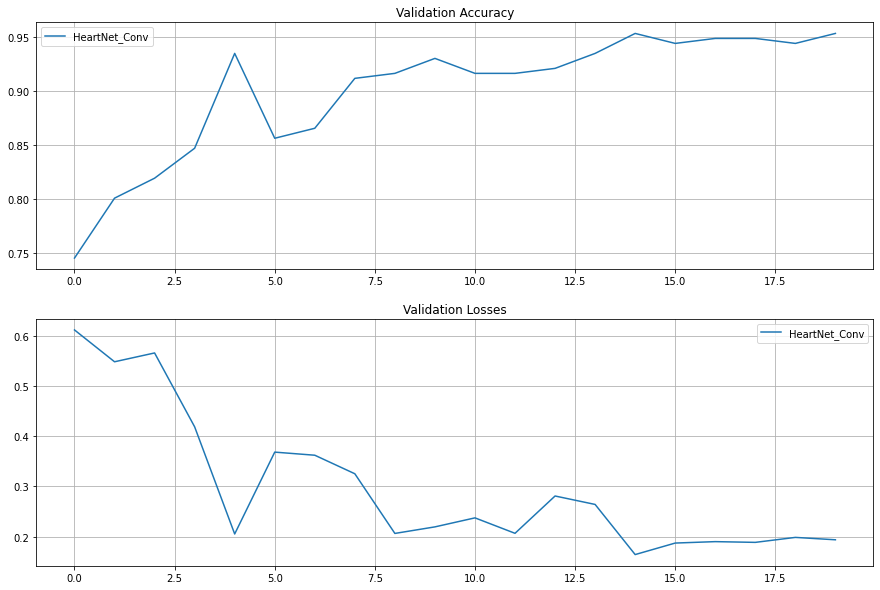

In [ ]:
fig,(ax,bx) = plt.subplots(2,figsize=(15,10))
for experiment_id in accuracies.keys():
    ax.plot(accuracies[experiment_id], label=experiment_id)
    ax.legend()
    ax.set_title('Validation Accuracy');
ax.grid()
for experiment_id in accuracies.keys():
    bx.plot(losses[experiment_id], label=experiment_id)
    bx.legend()
    bx.set_title('Validation Losses');
bx.grid()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
y_pred = model.forward(X_test.to(device)).argmax(dim=1)
(y_pred.cpu() == y_test).float().mean().data

tensor(0.9167)

In [ ]:
recall_score(y_pred.cpu().numpy(),y_test.cpu(),average='macro')

0.7463537303525996

In [ ]:
#save
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in heart_net_conv.state_dict():
    print(param_tensor, "\t", heart_net_conv.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([10, 1, 3, 23])
conv1.bias 	 torch.Size([10])
conv2.weight 	 torch.Size([15, 10, 2, 11])
conv2.bias 	 torch.Size([15])
conv3.weight 	 torch.Size([20, 15, 3, 11])
conv3.bias 	 torch.Size([20])
fc1.weight 	 torch.Size([100, 2160])
fc1.bias 	 torch.Size([100])
fc2.weight 	 torch.Size([20, 100])
fc2.bias 	 torch.Size([20])
fc3.weight 	 torch.Size([4, 20])
fc3.bias 	 torch.Size([4])


In [ ]:
# Specify a path
PATH = ...

# Save
torch.save(heart_net_conv.state_dict(), PATH)

# Load
# lenet5.load_state_dict(torch.load(PATH))
# lenet5.eval()